In [1]:
import igraph as ig
import numpy as np
import pandas as pd
import copy
import math
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from collections import Counter

In [2]:
datadir = '../Datasets/'
## define the colors and node sizes here
cls_edges = 'gainsboro'
cls = ['silver','dimgray','black']
sz = [6,9,12]

In [3]:
def deg_uncorr(G):
    n_nodes = G.vcount()
    n_edges = G.ecount()
    avg_deg = 2*n_edges / n_nodes
    degrees = G.degree()
    deg_count = dict(Counter(degrees))
    deg_prob = {}
    for l,cnt in deg_count.items():
        d_l = cnt/n_nodes
        deg_prob[l] = (l * d_l) / avg_deg
    deg_uncorr = sum([l*q for l,q in deg_prob.items()])
    return deg_uncorr

## Degree correlation functions
# undirected
def deg_corr(G):
    idx = {v:k for k,v in enumerate([i for i in set(G.degree())])}
    idx_inv = {k:v for k,v in enumerate(idx)}
    deg = G.degree()
    L = [[] for i in range(len(idx))]
    for v in G.vs():
        w = [deg[i] for i in G.neighbors(v)] 
        L[idx[v.degree()]].extend(w)
    return {idx_inv[i]:np.mean(L[i]) for i in range(len(L))}

## degree correlation for neutral graph with degree distribution in G
def deg_corr_neutral(G, mode='all'):
    x = G.degree(mode=mode)
    return np.mean([i**2 for i in x])/np.mean(x)    

## k_nn^{mode1,mode2}(l) : average mode2-degree of mode1-neighbours of nodes with mode1-degree = l
def deg_corr_directed(G, mode1='all', mode2='all'):
    idx = {v:k for k,v in enumerate([i for i in set(G.degree(mode=mode1))])}
    idx_inv = {k:v for k,v in enumerate(idx)}
    deg = G.degree(mode=mode2)
    L = [[] for i in range(len(idx))]
    for v in G.vs():
        w = [deg[i] for i in G.neighbors(v, mode='out')] ## do each link only once
        L[idx[v.degree(mode=mode1)]].extend(w)
    return {idx_inv[i]:np.mean(L[i]) for i in range(len(L)) if len(L[i])>0}

## Correlation exponent via linear regression (taking logs)
def corr_exp(G):
    ## compute knn's
    knn = deg_corr(G)
    # Fit the regression
    regressor = LinearRegression()  
    x = [np.log(i) for i in knn.keys()]
    y = [np.log(i) for i in knn.values()]
    regressor.fit(np.array(x).reshape(-1,1), y)
    return regressor.coef_[0]

## for a fixed l -- can be slow for multiple l's
def rich_club(g, l=1):
    g.vs()['degree'] = g.degree()
    l_max = np.max(g.degree())
    c = Counter(g.degree())
    n = g.vcount()
    moment = np.sum([k*c[k]/n for k in c])**2
    S = [k*c[k]/n for k in c if k>=l]
    phi_hat = np.sum([x*y for x in S for y in S])*g.ecount()/moment
    G = g.subgraph([v for v in g.vs() if v['degree']>=l])
    phi = G.ecount()
    return phi/phi_hat     


In [4]:
# This is adopted from networkx
# We customize the function to stop when all the edges in graph are switched at least once
from networkx.utils import py_random_state
@py_random_state(3)
def double_edge_swap(G, nswap=1, max_tries=100, seed=None, verbose=False):
    """Swap two edges in the graph while keeping the node degrees fixed.

    A double-edge swap removes two randomly chosen edges u-v and x-y
    and creates the new edges u-x and v-y::

     u--v            u  v
            becomes  |  |
     x--y            x  y

    If either the edge u-x or v-y already exist no swap is performed
    and another attempt is made to find a suitable edge pair.

    Parameters
    ----------
    G : graph
       An undirected graph

    nswap : integer (optional, default=1)
       Number of double-edge swaps to perform

    max_tries : integer (optional)
       Maximum number of attempts to swap edges

    seed : integer, random_state, or None (default)
        Indicator of random number generation state.
        See :ref:`Randomness<randomness>`.

    Returns
    -------
    G : graph
       The graph after double edge swaps.

    Notes
    -----
    Does not enforce any connectivity constraints.

    The graph G is modified in place.
    """
    original_G = G.copy()
    n_not_swiched_e = len(original_G.edges)
    if G.is_directed():
        raise nx.NetworkXError("double_edge_swap() not defined for directed graphs.")
    if nswap > max_tries:
        raise nx.NetworkXError("Number of swaps > number of tries allowed.")
    if len(G) < 4:
        raise nx.NetworkXError("Graph has less than four nodes.")
    # Instead of choosing uniformly at random from a generated edge list,
    # this algorithm chooses nonuniformly from the set of nodes with
    # probability weighted by degree.
    n = 0
    swapcount = 0
    keys, degrees = zip(*G.degree())  # keys, degree
    cdf = nx.utils.cumulative_distribution(degrees)  # cdf of degree
    discrete_sequence = nx.utils.discrete_sequence
    while swapcount < nswap:
        #        if random.random() < 0.5: continue # trick to avoid periodicities?
        # pick two random edges without creating edge list
        # choose source node indices from discrete distribution
        (ui, xi) = discrete_sequence(2, cdistribution=cdf, seed=seed)
        if ui == xi:
            continue  # same source, skip
        u = keys[ui]  # convert index to label
        x = keys[xi]
        # choose target uniformly from neighbors
        v = seed.choice(list(G[u]))
        y = seed.choice(list(G[x]))
        if v == y:
            continue  # same target, skip
        if (x not in G[u]) and (y not in G[v]):  # don't create parallel edges
            G.add_edge(u, x)
            G.add_edge(v, y)
            G.remove_edge(u, v)
            G.remove_edge(x, y)
            
            # If the edge is not switched, we are able to remove that edge from the original graph 
            # and the number of remaining not switched edges decreases by 1.
            # else if the edge is already switched, we are not able to remove that edge from the original graph
            # and the number of remaining not switched edges is unchanged.
            # The stopping criteria is when the number of not switched edges equals 0.
            try:
                original_G.remove_edge(u,v)
                n_not_swiched_e -= 1
            except:
                pass
            try:
                original_G.remove_edge(x,y)
                n_not_swiched_e -= 1
            except:
                pass
            # log
            if verbose:
                if n % 100000 == 0:
                    print('Trial: {} - Num edges not switched: {}'.format(n, n_not_swiched_e))
            # stopping criteria
            if n_not_swiched_e == 0:
                if verbose:
                    print('Trial: {} - Num edges not switched: {}'.format(n, n_not_swiched_e))
                return G, original_G
            swapcount += 1
        if n >= max_tries:
            e = (
                f"Maximum number of swap attempts ({n}) exceeded "
                f"before desired swaps achieved ({nswap})."
            )
            raise nx.NetworkXAlgorithmError(e)
        n += 1
    return G, original_G

## Problem 1

In [4]:
## read the GitHub edge list as tuples and build undirected graph
D = pd.read_csv(datadir+'GitHubDevelopers/musae_git_edges.csv')
tuples = [tuple(x) for x in D.values]
gh = ig.Graph.TupleList(tuples, directed = False)

## read node features
X = pd.read_csv(datadir+'GitHubDevelopers/musae_git_target.csv')

## map node names in edgelist to indices in the graph
idx = [int(i) for i in gh.vs['name']]
sorterIndex = dict(zip(idx,range(len(idx))))
X['Rank'] = X['id'].map(sorterIndex) 
X.sort_values(['Rank'], ascending=[True],inplace=True)
X.dropna(inplace=True)
lbl = ['web','ml']     ## node labels

## there are 2 node types: ml or web
gh.vs['lbl'] = [lbl[i] for i in list(X['ml_target'])]

## build the subgraphs
gh_ml = gh.subgraph([v for v in gh.vs() if v['lbl']=='ml'])
gh_web = gh.subgraph([v for v in gh.vs() if v['lbl']=='web'])

## there are 9739 ml developers and 27961 web developers
print('GitHub nodes:',gh.vcount(),'; ml developers:',gh_ml.vcount(),'; web developers:',gh_web.vcount())

GitHub nodes: 37700 ; ml developers: 9739 ; web developers: 27961


### Problem 1a

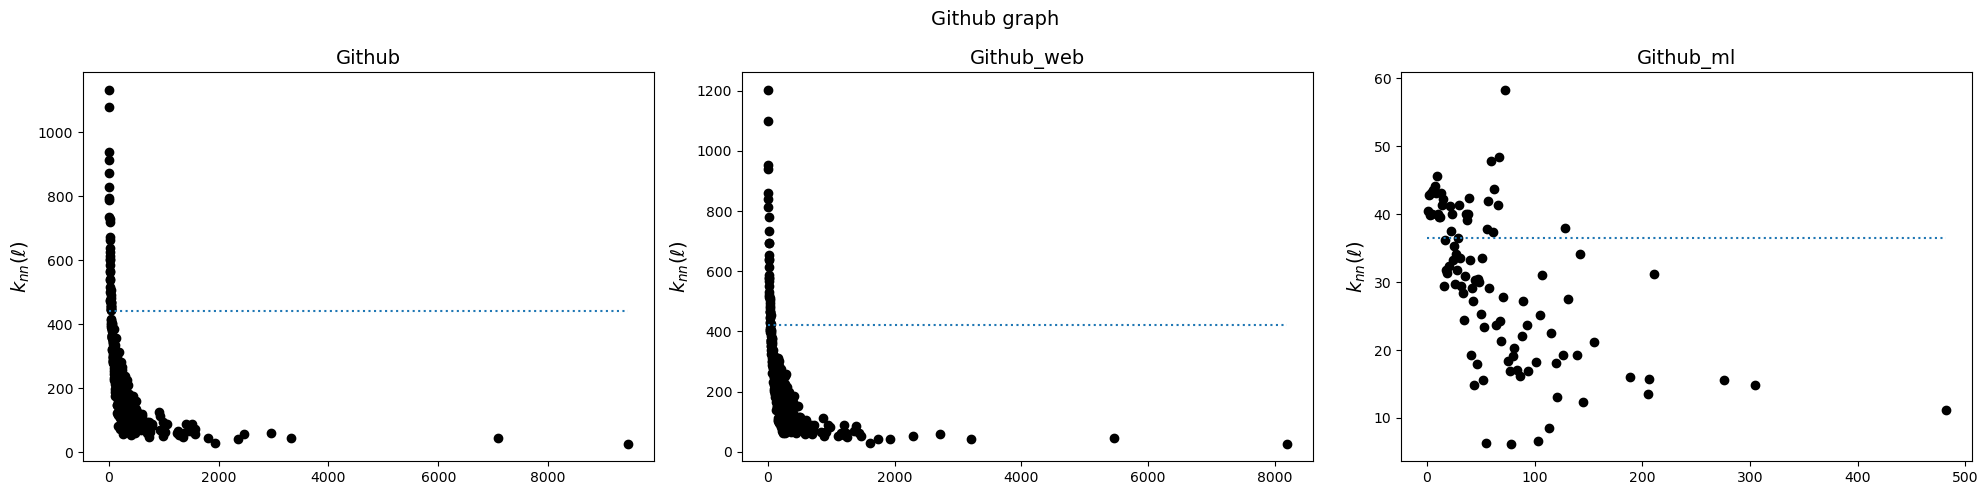

In [6]:
graphs = {
    'Github': gh,
    'Github_web': gh_web,
    'Github_ml': gh_ml,
}
fig, axes = plt.subplots(ncols=3, figsize=[20,5])
for idx,g_name in enumerate(graphs):
    g = graphs[g_name]
    knn = deg_corr(g)
    ax = axes[idx]
    x = list(knn.keys())
    y = list(knn.values())
    r = deg_corr_neutral(g)
    ax.scatter(x, y, c='black')
    ax.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
    ax.set_ylabel(r'$k_{nn}(\ell)$', fontsize=14)
    ax.set_title(g_name, fontsize=14)
plt.suptitle('Github graph', fontsize=14)
plt.tight_layout()
plt.show()

### Problem 1b

In [7]:
for g in [gh_ml, gh_web, gh]:
    ## drop isolated vertices (i.e. without in-state connections)
    g = g.subgraph([v for v in g.vs() if v.degree()>0])
    ## remove loops
    g = g.simplify(multiple=False)
    r = g.assortativity_degree()
    print(f'r = {r}')

r = -0.09098692775064465
r = -0.08714757315866849
r = -0.07521713413904484


### Problem 1c

In [8]:
for g in [gh_ml, gh_web, gh]:
    ## drop isolated vertices (i.e. without in-state connections)
    g = g.subgraph([v for v in g.vs() if v.degree()>0])
    ## remove loops
    g = g.simplify(multiple=False)
    mu = corr_exp(g)
    print(f'mu = {mu}')

mu = -0.25142348768180356
mu = -0.5151040696086915
mu = -0.5076879013701243


### Problem 1d

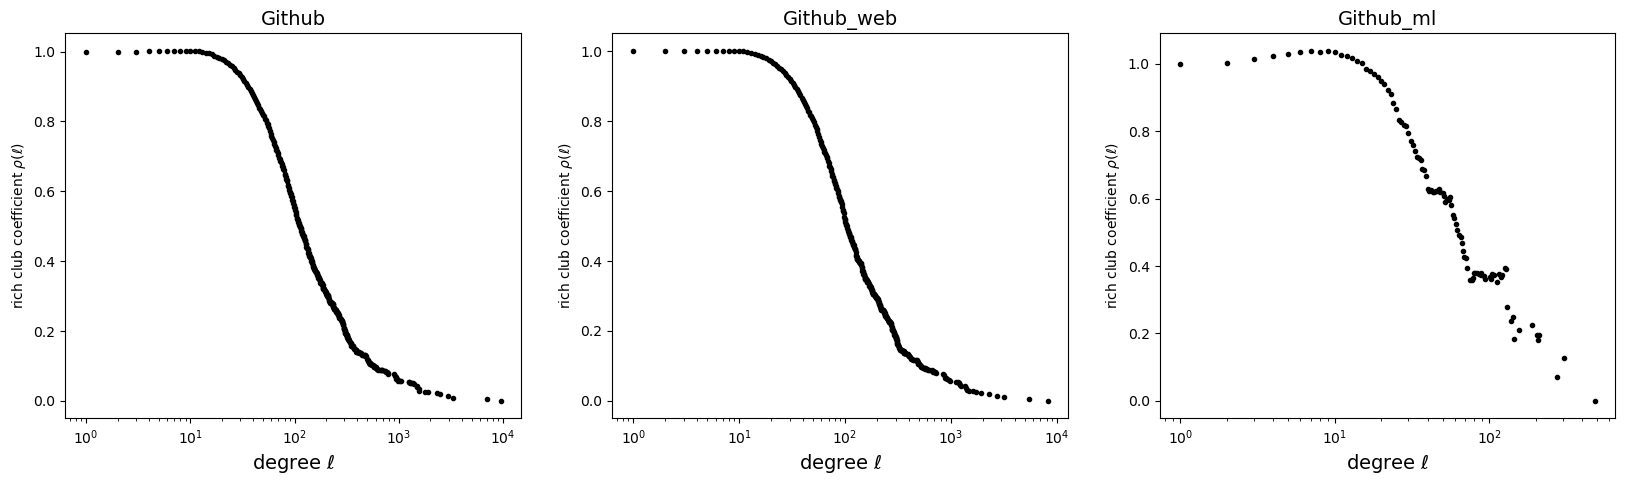

In [9]:
graphs = {
    'Github': gh,
    'Github_web': gh_web,
    'Github_ml': gh_ml,
}
fig, axes = plt.subplots(ncols=3, figsize=[20,5])
for idx,g_name in enumerate(graphs):
    g = copy.deepcopy(graphs[g_name])
    d = list(set(g.degree()))
    rc = []
    for i in d:
        rc.append(rich_club(g, l=i))
    axes[idx].semilogx(d,rc,'.',c='black')
    axes[idx].set_xlabel(r'degree $\ell$', fontsize=14)
    axes[idx].set_ylabel(r'rich club coefficient $\rho(\ell)$');
    axes[idx].set_title(g_name, fontsize=14)
plt.show()

## Problem 2

In [4]:
gh = nx.Graph()

## read the GitHub edge list as tuples and build undirected graph
D = pd.read_csv(datadir+'GitHubDevelopers/musae_git_edges.csv')
tuples = [tuple(x) for x in D.values]
gh.add_edges_from(tuples)

In [5]:
# This is adopted from networkx
# We customize the function to stop when all the edges in graph are switched at least once
from networkx.utils import py_random_state
@py_random_state(3)
def double_edge_swap(G, nswap=1, max_tries=100, seed=None):
    """Swap two edges in the graph while keeping the node degrees fixed.

    A double-edge swap removes two randomly chosen edges u-v and x-y
    and creates the new edges u-x and v-y::

     u--v            u  v
            becomes  |  |
     x--y            x  y

    If either the edge u-x or v-y already exist no swap is performed
    and another attempt is made to find a suitable edge pair.

    Parameters
    ----------
    G : graph
       An undirected graph

    nswap : integer (optional, default=1)
       Number of double-edge swaps to perform

    max_tries : integer (optional)
       Maximum number of attempts to swap edges

    seed : integer, random_state, or None (default)
        Indicator of random number generation state.
        See :ref:`Randomness<randomness>`.

    Returns
    -------
    G : graph
       The graph after double edge swaps.

    Notes
    -----
    Does not enforce any connectivity constraints.

    The graph G is modified in place.
    """
    original_G = G.copy()
    n_not_swiched_e = len(original_G.edges)
    if G.is_directed():
        raise nx.NetworkXError("double_edge_swap() not defined for directed graphs.")
    if nswap > max_tries:
        raise nx.NetworkXError("Number of swaps > number of tries allowed.")
    if len(G) < 4:
        raise nx.NetworkXError("Graph has less than four nodes.")
    # Instead of choosing uniformly at random from a generated edge list,
    # this algorithm chooses nonuniformly from the set of nodes with
    # probability weighted by degree.
    n = 0
    swapcount = 0
    keys, degrees = zip(*G.degree())  # keys, degree
    cdf = nx.utils.cumulative_distribution(degrees)  # cdf of degree
    discrete_sequence = nx.utils.discrete_sequence
    while swapcount < nswap:
        #        if random.random() < 0.5: continue # trick to avoid periodicities?
        # pick two random edges without creating edge list
        # choose source node indices from discrete distribution
        (ui, xi) = discrete_sequence(2, cdistribution=cdf, seed=seed)
        if ui == xi:
            continue  # same source, skip
        u = keys[ui]  # convert index to label
        x = keys[xi]
        # choose target uniformly from neighbors
        v = seed.choice(list(G[u]))
        y = seed.choice(list(G[x]))
        if v == y:
            continue  # same target, skip
        if (x not in G[u]) and (y not in G[v]):  # don't create parallel edges
            G.add_edge(u, x)
            G.add_edge(v, y)
            G.remove_edge(u, v)
            G.remove_edge(x, y)
            
            # If the edge is not switched, we are able to remove that edge from the original graph 
            # and the number of remaining not switched edges decreases by 1.
            # else if the edge is already switched, we are not able to remove that edge from the original graph
            # and the number of remaining not switched edges is unchanged.
            # The stopping criteria is when the number of not switched edges equals 0.
            try:
                original_G.remove_edge(u,v)
                n_not_swiched_e -= 1
            except:
                pass
            try:
                original_G.remove_edge(x,y)
                n_not_swiched_e -= 1
            except:
                pass
            # log
            if n % 100000 == 0:
                print('Trial: {} - Num edges not switched: {}'.format(n, n_not_swiched_e))
            # stopping criteria
            if n_not_swiched_e == 0:
                print('Trial: {} - Num edges not switched: {}'.format(n, n_not_swiched_e))
                return G
            swapcount += 1
        if n >= max_tries:
            e = (
                f"Maximum number of swap attempts ({n}) exceeded "
                f"before desired swaps achieved ({nswap})."
            )
            raise nx.NetworkXAlgorithmError(e)
        n += 1
    return G

In [6]:
gh_switched = gh.copy()
try:
    double_edge_swap(gh_switched, nswap=1e10, max_tries=1e10)
except Exception as e: 
    print(e)

Trial: 0 - Num edges not switched: 289001
Trial: 100000 - Num edges not switched: 158357
Trial: 200000 - Num edges not switched: 88249
Trial: 300000 - Num edges not switched: 49933
Trial: 400000 - Num edges not switched: 28940
Trial: 500000 - Num edges not switched: 16971
Trial: 600000 - Num edges not switched: 10116
Trial: 700000 - Num edges not switched: 6193
Trial: 800000 - Num edges not switched: 3888
Trial: 900000 - Num edges not switched: 2487
Trial: 1000000 - Num edges not switched: 1652
Trial: 1100000 - Num edges not switched: 1142
Trial: 1200000 - Num edges not switched: 774
Trial: 1300000 - Num edges not switched: 541
Trial: 1500000 - Num edges not switched: 270
Trial: 1600000 - Num edges not switched: 195
Trial: 1700000 - Num edges not switched: 141
Trial: 1800000 - Num edges not switched: 97
Trial: 1900000 - Num edges not switched: 80
Trial: 2000000 - Num edges not switched: 61
Trial: 2100000 - Num edges not switched: 50
Trial: 2200000 - Num edges not switched: 35
Trial: 23

In [10]:
# Convert graph from nx to ig
gh_ig = ig.Graph.TupleList(gh.edges, directed=False)
gh_switched_ig = ig.Graph.TupleList(gh_switched.edges, directed=False)

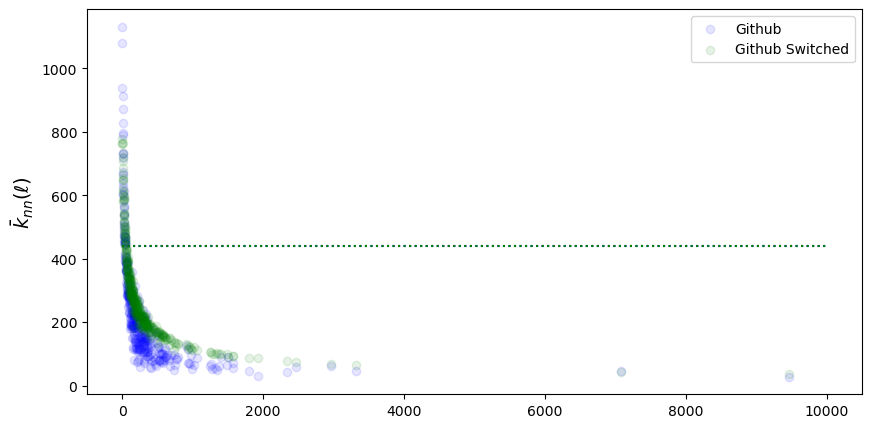

In [12]:
# graphs = {
#     'Github': gh,
#     'Github Switched': gh_switched_ig,
# }
# fig, axes = plt.subplots(ncols=2, figsize=[20,7])
# for idx,g_name in enumerate(graphs):
#     g = graphs[g_name]
#     knn = deg_corr(g)
#     ax = axes[idx]
#     x = list(knn.keys())
#     y = list(knn.values())
#     r = deg_corr_neutral(g)
#     ax.scatter(x, y, c='black')
#     ax.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
#     ax.set_ylabel(r'$k_{nn}(\ell)$', fontsize=14)
#     ax.set_title(g_name, fontsize=14)
# plt.suptitle('Github graph', fontsize=14)
# plt.tight_layout()
# plt.show()

# Plot two functions in one figure to better see whether two functions are separated from each other or not.
fig, ax = plt.subplots(figsize=[10,5])
knn = deg_corr(gh_ig)
knn_s = deg_corr(gh_switched_ig)
r = deg_corr_neutral(gh_ig)
r_s = deg_corr_neutral(gh_switched_ig)
ax.scatter(list(knn.keys()), list(knn.values()), c='blue', alpha=0.1, label='Github')
ax.scatter(list(knn_s.keys()), list(knn_s.values()), c='green', alpha=0.1, label='Github Switched')
ax.hlines(y=r,xmin=0,xmax=10000,linestyles=':', color='blue')
ax.hlines(y=r_s,xmin=0,xmax=10000,linestyles=':', color='green')
ax.set_ylabel(r'$\bar{k}_{nn}(\ell)$', fontsize=14)
plt.legend()
plt.show()

**Observation.** The original function $k_{nn}$ and its the randomized counterpart $\bar{k}_{nn}$ are similar and indistinguishable. Therefore, we can conclude that the correlations in Github graph are structural and explanable by the degree distribution. The Github graph is uncorrelated graph.

## Problem 3

In [6]:
gh = nx.Graph()

## read the GitHub edge list as tuples and build undirected graph
D = pd.read_csv(datadir+'GitHubDevelopers/musae_git_edges.csv')
tuples = [tuple(x) for x in D.values]
gh.add_edges_from(tuples)

# 3cm
cs = [0.5, 1, 2]
n_edges = len(gh.edges())
seed = 2022

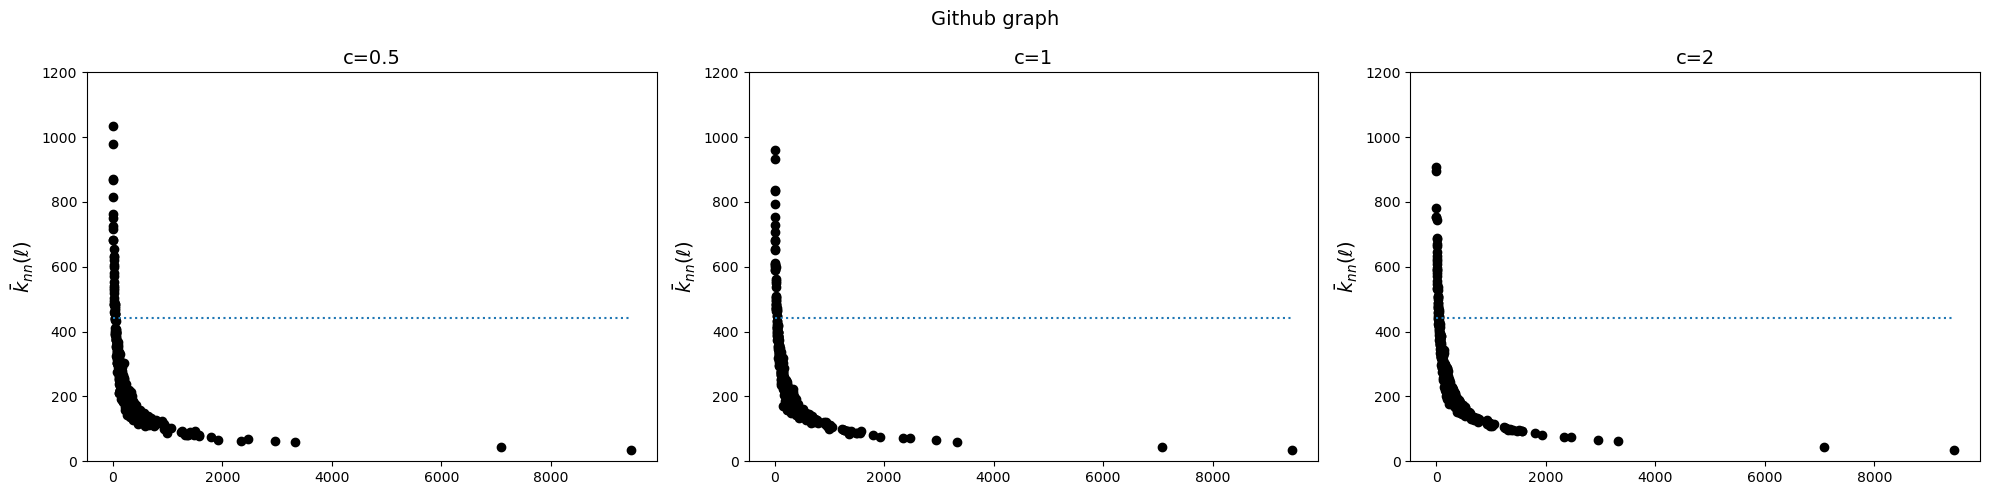

In [7]:
# Run cm and plot
switched_graphs = []
for c in cs:
    trial_count = int(c * n_edges * 1/2)
    gh_switched = gh.copy()
    try:
        nx.double_edge_swap(gh_switched, nswap=trial_count, max_tries=trial_count*2, seed=seed)
    except Exception as e: 
        print(e)
    # convert switched graph from networkx to igraph
    switched_graphs.append(ig.Graph.TupleList(gh_switched.edges, directed=False)) 
    
fig, axes = plt.subplots(ncols=3, figsize=[20,5])
for idx in range(len(switched_graphs)):
    g = switched_graphs[idx]
    knn = deg_corr(g)
    ax = axes[idx]
    x = list(knn.keys())
    y = list(knn.values())
    r = deg_corr_neutral(g)
    ax.scatter(x, y, c='black')
    ax.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
    ax.set_ylim(0, 1200)
    ax.set_ylabel(r'$\bar{k}_{nn}(\ell)$', fontsize=14)
    ax.set_title('c={}'.format(cs[idx]), fontsize=14)
plt.suptitle('Github graph', fontsize=14)
plt.tight_layout()
plt.show()

In [8]:
for c in cs:
    nswap = int(c * n_edges * 2/2)
    gh_switched = gh.copy()
    try:
        _, gh_original = double_edge_swap(
            gh_switched, nswap=nswap, max_tries=nswap*2, seed=seed, verbose=False)
    except Exception as e: 
        print(e)
    unswitched_es = gh_original.edges
    exp_ratio = len(unswitched_es) / n_edges
    theo_ratio = math.pow(math.e, -2*c)
    print('c={}\t m={}\t nswap={}\t exp_ratio={:.4f}\t theo_ratio={:.4f}'.format(
        c, n_edges, nswap, exp_ratio, theo_ratio))   

c=0.5	 m=289003	 nswap=144501	 exp_ratio=0.3732	 theo_ratio=0.3679
c=1	 m=289003	 nswap=289003	 exp_ratio=0.1433	 theo_ratio=0.1353
c=2	 m=289003	 nswap=578006	 exp_ratio=0.0248	 theo_ratio=0.0183


## Problem 5

In [19]:
## fast Chung-Lu: generate m edges w.r.t. distribution d
def fastCL(d, m):
    n = len(d)
    s = np.sum(d)
    p = [i/s for i in d]
    target = m
    tples = []
    ## generate edges (tuples), drop collisions, until m edges are obtained.
    while len(tples) < target:
        s = target - len(tples)
        e0 = np.random.choice(n, size=s, replace=True, p=p)
        e1 = np.random.choice(n, size=s, replace=True, p=p)
        tples.extend([(min(e0[i],e1[i]),max(e0[i],e1[i])) for i in range(len(e0)) if e0[i]!=e1[i]]) ## ignore loops
        tples = list(set(tples)) ## drop collisions
    return tples

#
def plot_fp_and_rc(g):
    fig, ax = plt.subplots(ncols=2, figsize=[20,5])
    # friendship paradox
    deg = [v.degree() for v in g.vs()]
    nad = []
    for v in g.vs():
        nv = g.neighbors(v)
        nad.append(np.mean([deg[i] for i in nv]))

    ax[0].scatter(deg, nad, c='black', marker='.', alpha=0.1)
    ax[0].set_xlim((0,200))
    ax[0].set_ylim((0,200))
    ax[0].set_xlabel('node degree', fontsize=14)
    ax[0].set_ylabel('average neighbour degree', fontsize=14);
    ax[0].plot([0,200],[0,200],'--', c='gray')
    ax[0].set_title('Friendship paradox r={:.04f}'.format(g.assortativity_degree()))
    # rich club coefficient
    d = list(set(g.degree()))
    rc = []
    for i in d:
        rc.append(rich_club(g, l=i))
    ax[1].semilogx(d,rc,'.',c='black')
    ax[1].set_xlabel(r'degree $\ell$',fontsize=14)
    ax[1].set_ylabel(r'rich club coefficient $\rho(\ell)$')
    ax[1].set_title('Rich club coefficient')
    plt.show()

gamma=2.1


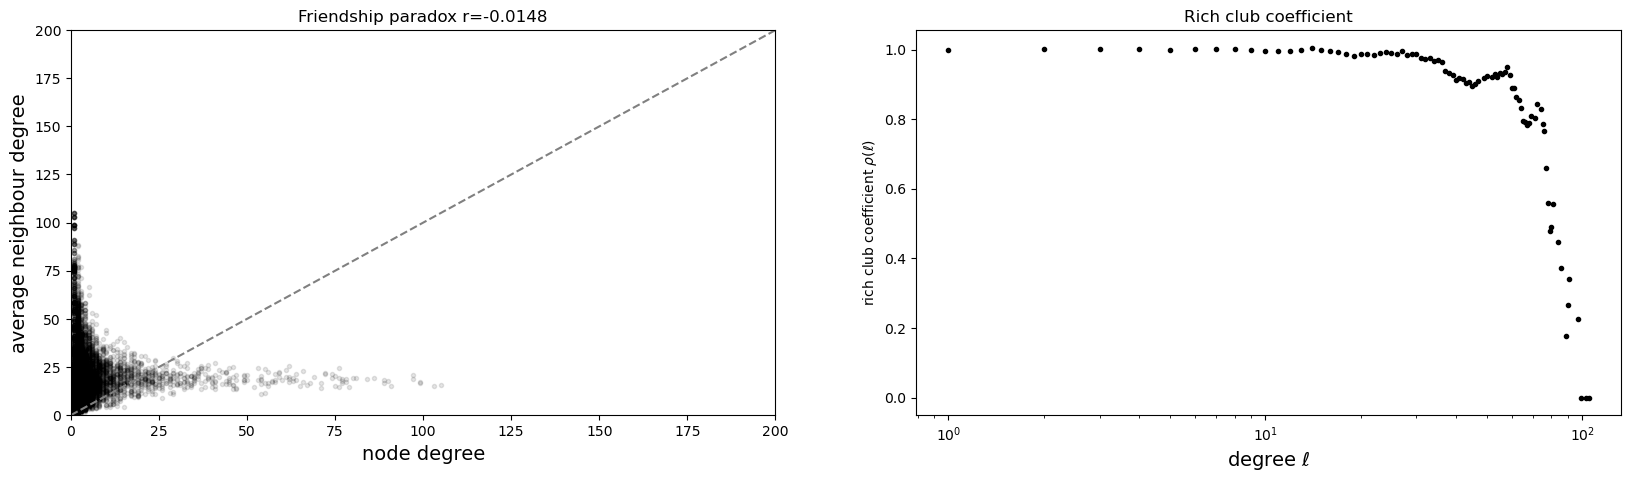

gamma=2.5


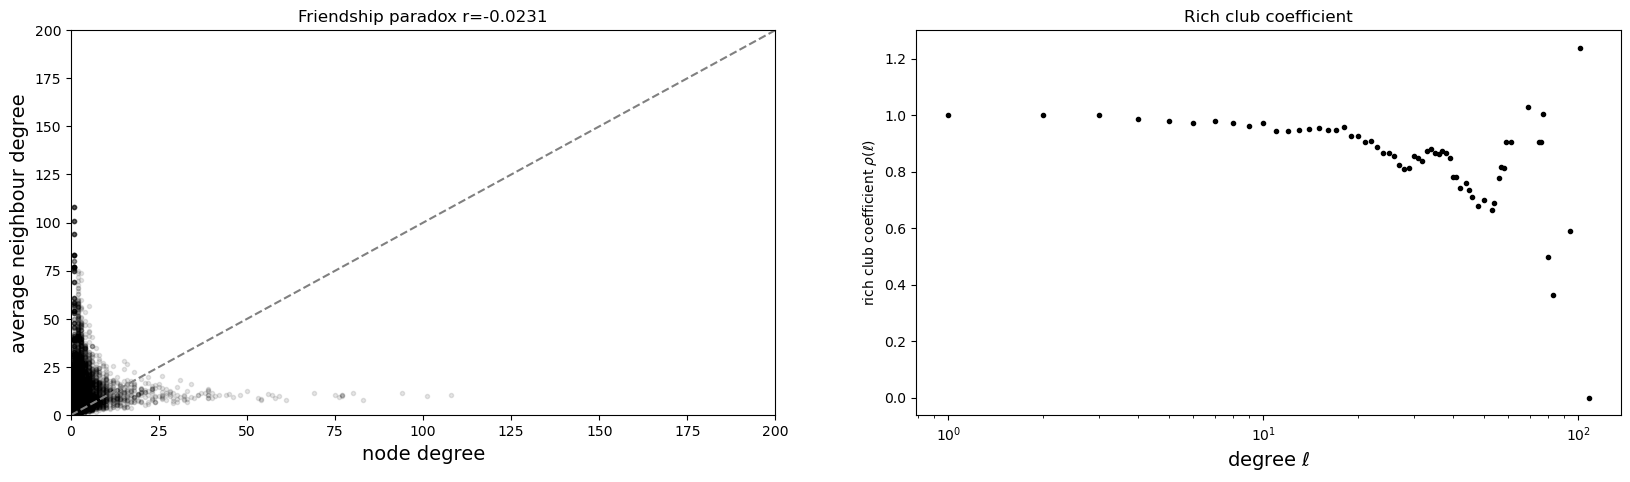

gamma=2.9


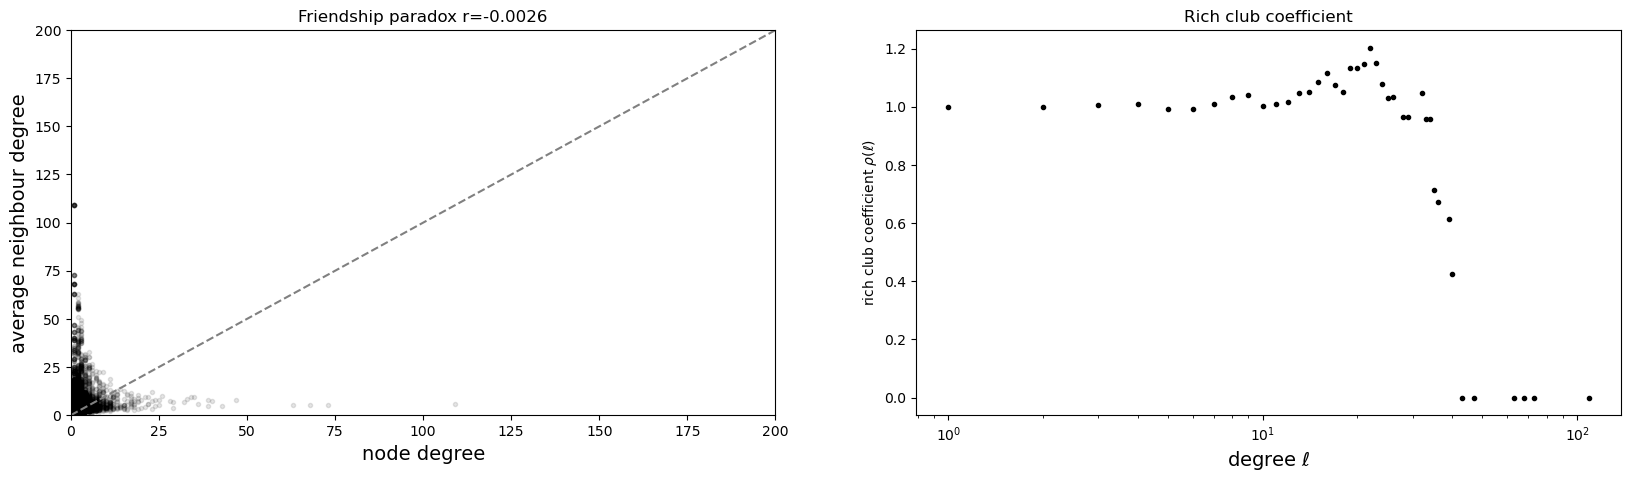

In [20]:
## power law graph
n = 10000

## min and max degrees
delta = 1
Delta = 100

gamma_list = [2.1, 2.5, 2.9]
for gamma in gamma_list:
    print(f'gamma={gamma}')
    ## generate degrees
    W = []
    for i in np.arange(1, n+1):
        W.append(delta * (n/(i-1+n/(Delta/delta)**(gamma-1)))**(1/(gamma-1)))

    # deg = [int(np.round(w)) for w in W] ## to enforce integer weights, not an obligation
    deg = W

    ## generate graph with Chung-Lu model
    m = int(np.mean(deg)*n/2)
    tpl = fastCL(deg,m)
    g_i = ig.Graph.TupleList(tpl)
    plot_fp_and_rc(g_i)

**Observations.**
- Friendship paradox:
    + In both figures, the region above the line is denser (especially with low gamma value), this indicates that there are many low degree nodes which mostly tend to connect to higher degree nodes.
    + The presence of this “paradox” seems to be more visible when the value of $\gamma$ is low. 
- Rich-club coefficient:
    + The rich-club ratio $\rho(1) = 1$ in three plots. 
    + When $\gamma = 2.1$, the curve starts to decrease when the degree equals to 10. When the value of the degree equals to 100, the curve start to decrease significantly. This indicates that there is no clear rich-club phenomenon here.
    + When $\gamma = 2.5$, the curve decreases slightly and then start increase to 1. There are only a few the number of points which has the rich-club coefficient approximatly 1.2 and there are also a few number of points with low rich-club coefficient value. We conclude that there is no indication of a rich-club phenomenon here.
    + When $\gamma = 2.9$. The curve increases slightly when degree equals to 10, and then decreases significantly. This indicates that there is no rich-club phenomenon.